In [1]:
import jax
import numpy as onp
import jax.numpy as jnp
from jax import grad, jacfwd
import mesh_processing as mp
import pmm

try:
    import meshplot as mplot
    meshplot_available = True
except ImportError as e:
    meshplot_available = False

import matplotlib.pyplot as plt

In [ ]:
V_pc,F_pc = mp.objloader('project2/meshes/Spheroids/','partial_cubified.obj')
V_s,F_s = mp.objloader('project2/meshes/Spheroids/','Sphere.obj')
V_c,F_c = mp.objloader('project2/meshes/Spheroids/','cubified.obj')
V_t,F_t = mp.objloader('project2/meshes/Torus_remesh/','Torus.obj')
V_t1,F_t1 = mp.objloader('project2/meshes/Torus_remesh/','Torus_sub1.obj')
V_t2,F_t2 = mp.objloader('project2/meshes/Torus_remesh/','Torus_sub2.obj')

/home/dith/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [ ]:
def to_numpy_array(X):
    Np_array = onp.zeros(X.shape)
    for n in range(X.shape[0]):
        Np_array[n] = X[n]
    return Np_array

def plot_mesh(V,F):
    if meshplot_available:
        V_plot = to_numpy_array(V)
        F_plot = to_numpy_array(F)
        mplot.plot(V_plot,F_plot)
    else:
        print('Did not plot - meshplot not available')

#plot_mesh(V_t,F_t)
#plot_mesh(V_c,F_c)
#plot_mesh(V_s,F_s)

In [ ]:
N_pc,A_pc = mp.compute_normals_and_areas(V_pc,F_pc)
N_s,A_s = mp.compute_normals_and_areas(V_s,F_s)
N_c,A_c = mp.compute_normals_and_areas(V_c,F_c)

In [ ]:
def center_of_mass(V,F):
    return (V[F[:,0]]+V[F[:,1]]+V[F[:,2]])/3

In [ ]:
def Gaussian_Kernel(sigma):
    def f(x,y):
        return jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma**2))
    return f

def Gaussian_Kernel_Norm(sigma):
    def f(norm):
        return jnp.exp(-norm**2/(2*sigma**2))
    return f
    

#Set Kernel

D = jnp.vectorize(lambda x,y: x - y)

def current_inner_product(m1,m2,n1,n2,sigma):
    Km = jnp.exp(-( \
        D(m1[:,0].reshape(-1,1),m2[:,0].reshape(1,-1))**2 + \
        D(m1[:,1].reshape(-1,1),m2[:,1].reshape(1,-1))**2 + \
        D(m1[:,2].reshape(-1,1),m2[:,2].reshape(1,-1))**2)*1 / (2*sigma**2))
    
    return jnp.sum(jnp.dot(n1, n2.T)*Km)

def distCurves(V1,F1,V2,F2, sigma, use_area_weights=False):
    N1,A1 = mp.compute_normals_and_areas(V1,F1)
    N2,A2 = mp.compute_normals_and_areas(V2,F2)
    if use_area_weights:
        N1 = N1*A1.reshape(-1,1)
        N2 = N2*A2.reshape(-1,1)
    M1 = center_of_mass(V1,F1)
    M2 = center_of_mass(V2,F2)
    
    product_aa =    current_inner_product(M1,M1,N1,N1,sigma)
    product_bb =    current_inner_product(M2,M2,N2,N2,sigma)
    product_ab =    current_inner_product(M1,M2,N1,N2,sigma)
    
    res = product_aa + product_bb - 2*product_ab
    
    return jnp.sqrt(jnp.clip(res, 0, None))

def minimized_distCurves(V1,F1,V2,F2,sigma):
    return min(distCurves(V1,F1,V2,F2,sigma), distCurves(V1,F1,-V2,F2,sigma))

In [7]:
def scalar_dist(c,V,F):
    return minimized_distCurves(V,F,V+c,F,2)

print(scalar_dist(jnp.float32(1),V_s,F_s))

863.11725


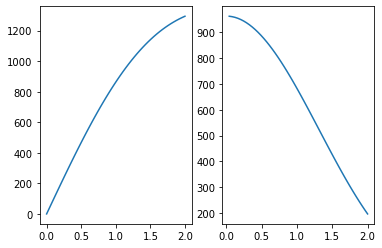

In [8]:
grad(scalar_dist)(jnp.float32(1.01),V_s,F_s)
x = onp.linspace(0, 2, 50)
y = [grad(scalar_dist)(jnp.float32(n),V_s,F_s) for n in x]
z = [scalar_dist(jnp.float32(n),V_s,F_s) for n in x]
plt.figure()
plt.subplot(1,2,1)
plt.plot(x,z)
plt.subplot(1,2,2)
plt.plot(x,y)
plt.show()

In [9]:
plot_mesh((-1)*V_s,F_s)

Did not plot - meshplot not available


In [10]:
print(scalar_dist(jnp.float32(1),V_s,F_s),scalar_dist(jnp.float32(-1),V_s,F_s))

863.11725 863.11725


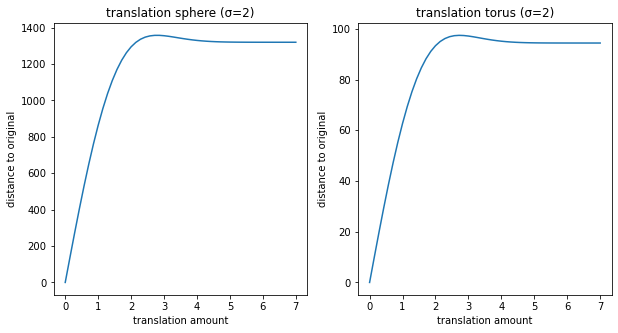

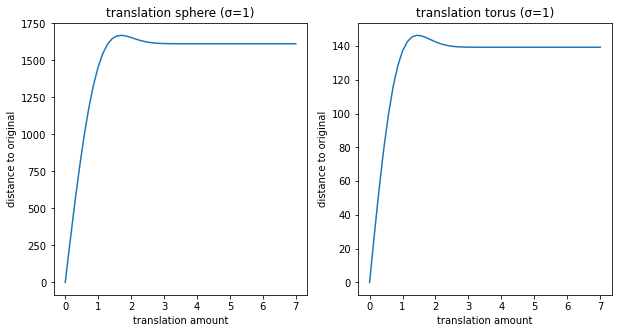

In [11]:
x = jnp.linspace(0, 7, 50)
y = pmm.translate_x(distCurves, V_s, F_s, x)
z = pmm.translate_x(distCurves, V_t, F_t, x)

fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('translation sphere (σ=2)')
plt.plot(x, y)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.subplot(1,2,2)
plt.title('translation torus (σ=2)')
plt.plot(x, z)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.savefig('project2/figures/translation_sigma_2.png')
plt.show()

x = jnp.linspace(0, 7, 50)
y = pmm.translate_x(distCurves, V_s, F_s, x, 1)
z = pmm.translate_x(distCurves, V_t, F_t, x, 1)

fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('translation sphere (σ=1)')
plt.plot(x, y)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.subplot(1,2,2)
plt.title('translation torus (σ=1)')
plt.plot(x, z)
plt.xlabel('translation amount')
plt.ylabel('distance to original')

plt.savefig('project2/figures/translation_sigma_1.png')
plt.show()

In [ ]:
x = jnp.linspace(0.1, 10, 50)
y = pmm.scale_x(distCurves, V_s, F_s, x)
z = pmm.scale_x(distCurves, V_t, F_t, x)

fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('scaling sphere along x')
plt.plot(x, y)
plt.xlabel('scaling factor')
plt.ylabel('distance to original')

plt.subplot(1,2,2)
plt.title('scaling torus along x')
plt.plot(x, z)
plt.xlabel('scaling factor')
plt.ylabel('distance to original')

plt.savefig('project2/figures/scaling.png')
plt.show()

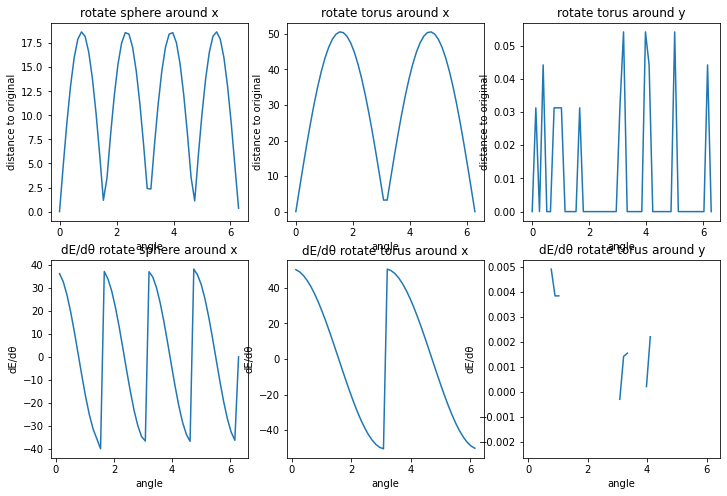

In [68]:
x = jnp.linspace(0, 2*jnp.pi, 50)
y = pmm.rotate_x(distCurves, V_s, F_s, x)
z1 = pmm.rotate_x(distCurves, V_t, F_t, x)
z2 = pmm.rotate_y(distCurves, V_t, F_t, x)
#print(x[4],jnp.where(jnp.isnan(z2)))

ddy  = [grad(lambda v: pmm.rotate_x(distCurves, V_s, F_s, jnp.array(v)))(v_) for v_ in x]
ddz1 = [grad(lambda v: pmm.rotate_x(distCurves, V_t, F_t, jnp.array(v)))(v_) for v_ in x]
ddz2 = [grad(lambda v: pmm.rotate_y(distCurves, V_t, F_t, jnp.array(v)))(v_) for v_ in x]

fig = plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('rotate sphere around x')
plt.plot(x, y)
plt.xlabel('angle')
plt.ylabel('distance to original')

plt.subplot(2,3,2)
plt.title('rotate torus around x')
plt.plot(x, z1)
plt.xlabel('angle')
plt.ylabel('distance to original')

plt.subplot(2,3,3)
plt.title('rotate torus around y')
plt.plot(x, z2)
plt.xlabel('angle')
plt.ylabel('distance to original')
            
plt.subplot(2,3,4)
plt.title('dE/dθ rotate sphere around x')
plt.plot(x, ddy)
plt.xlabel('angle')
plt.ylabel('dE/dθ')

plt.subplot(2,3,5)
plt.title('dE/dθ rotate torus around x')
plt.plot(x, ddz1)
plt.xlabel('angle')
plt.ylabel('dE/dθ')

plt.subplot(2,3,6)
plt.title('dE/dθ rotate torus around y')
plt.plot(x, ddz2)
plt.xlabel('angle')
plt.ylabel('dE/dθ')
plt.savefig('project2/figures/rotations_with_derivatives.png')
plt.show()

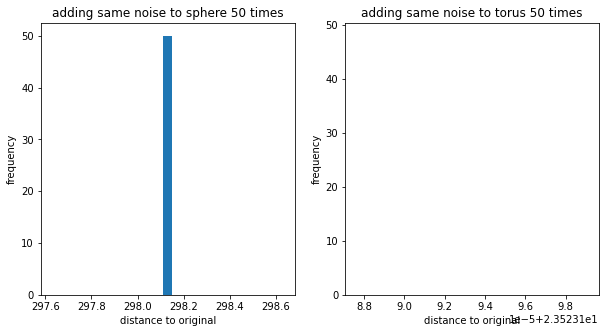

In [69]:
x = jnp.ones(50)*min_dist/2
y = pmm.add_noise(distCurves, V_s, F_s, x)
z = pmm.add_noise(distCurves, V_t, F_t, x)

fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('adding same noise to sphere 50 times')
plt.hist(y,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.title('adding same noise to torus 50 times')
plt.hist(z,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.savefig('project2/figures/adding_same_noise.png')
plt.show()

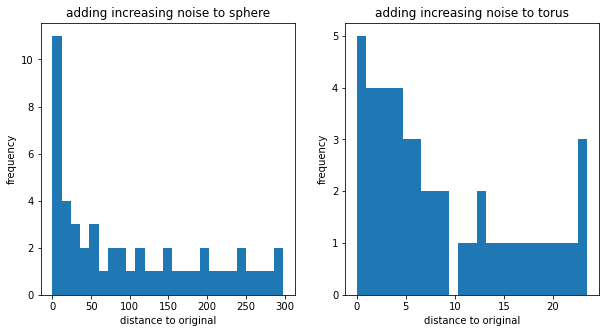

In [70]:
x = jnp.linspace(0,min_dist/2,50)
y = pmm.add_noise(distCurves, V_s, F_s, x)
z = pmm.add_noise(distCurves, V_t, F_t, x)

fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('adding increasing noise to sphere')
plt.hist(y,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.title('adding increasing noise to torus')
plt.hist(z,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')

plt.savefig('project2/figures/adding_increasing_noise.png')
plt.show()

In [84]:
x0 = jnp.linspace(0.0, 2*jnp.pi, 25)
y0 = pmm.rotate_x(distCurves, V_t, F_t, x0)

In [85]:
x1 = jnp.linspace(0.0, 2*jnp.pi, 25)
y1 = pmm.rotate_x(distCurves, V_t1, F_t1, x1)

In [86]:
x2 = jnp.linspace(0.0, 2*jnp.pi, 9)
y21 = pmm.rotate_x(distCurves, V_t2, F_t2, x2[:3])

In [87]:
y22 = pmm.rotate_x(distCurves, V_t2, F_t2, x2[3:6])

In [88]:
y23 = pmm.rotate_x(distCurves, V_t2, F_t2, x2[6:])

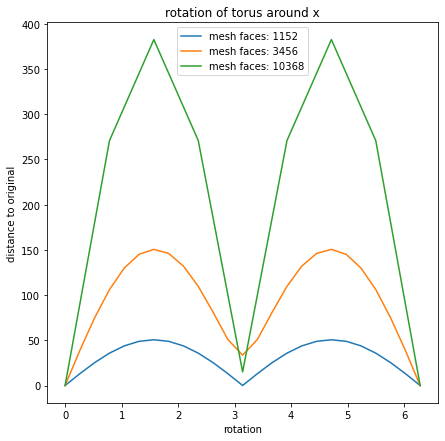

In [89]:
fig = plt.figure(figsize = (7,7))
plt.plot(x0, y0, label=f'mesh faces: {len(F_t)}')
plt.plot(x1, y1, label=f'mesh faces: {len(F_t1)}')
plt.plot(x2, jnp.concatenate([y21, y22, y23]), label=f'mesh faces: {len(F_t2)}')

plt.title('rotation of torus around x')
plt.xlabel('rotation')
plt.ylabel('distance to original')
plt.legend()
plt.savefig('project2/figures/effect_of_remeshing_no_norm.png')
plt.show()

In [78]:
x0 = jnp.linspace(0.0, 2*jnp.pi, 25)
y0 = pmm.rotate_x(lambda v0, f0, v1, f1, s: \
                  distCurves(v0,f0,v1,f1,s,use_area_weights=True), V_t, F_t, x0)

In [79]:
x1 = jnp.linspace(0.0, 2*jnp.pi, 25)
y1 = pmm.rotate_x(lambda v0, f0, v1, f1, s: \
                  distCurves(v0,f0,v1,f1,s,use_area_weights=True), V_t1, F_t1, x1)

In [80]:
x2 = jnp.linspace(0.0, 2*jnp.pi, 9)
y21 = pmm.rotate_x(lambda v0, f0, v1, f1, s: \
                   distCurves(v0,f0,v1,f1,s,use_area_weights=True), V_t2, F_t2, x2[:3])

In [81]:
y22 = pmm.rotate_x(lambda v0, f0, v1, f1, s: \
                   distCurves(v0,f0,v1,f1,s,use_area_weights=True), V_t2, F_t2, x2[3:6])

In [82]:
y23 = pmm.rotate_x(lambda v0, f0, v1, f1, s: \
                   distCurves(v0,f0,v1,f1,s,use_area_weights=True), V_t2, F_t2, x2[6:])

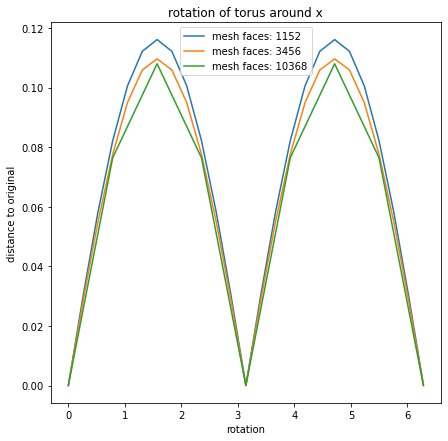

In [83]:
fig = plt.figure(figsize = (7,7))
plt.plot(x0, y0, label=f'mesh faces: {len(F_t)}')
plt.plot(x1, y1, label=f'mesh faces: {len(F_t1)}')
plt.plot(x2, jnp.concatenate([y21, y22, y23]), label=f'mesh faces: {len(F_t2)}')

plt.title('rotation of torus around x')
plt.xlabel('rotation')
plt.ylabel('distance to original')
plt.legend()
plt.savefig('project2/figures/effect_of_remeshing_with_norm.png')
plt.show()

In [23]:
print(distCurves(V_t, F_t, V_t2, F_t2, 2))
print(distCurves(V_t, F_t, V_t1, F_t1, 2))
print(distCurves(V_t1, F _t1, V_t2, F_t2, 2))

560.10785
137.97502
423.8723


In [24]:
F = jnp.array([[0,1,2],[3,2,1]])

num_verts = 50
num_faces = 5

for i in range(1000):
    F = onp.random.randint(0, num_verts, (num_faces,3 ))
    mask = F[:,0] == F[:,1]
    #print('F01',F)                           # F01 [[1 0 0]]
    #print('mask01', mask)                    # mask01 [False]
    F[mask,1] += 1
    mod_mask = F[:,1] == num_verts
    F[mod_mask,1] = 0
    
    mask = F[:,0] == F[:,2]
    #print('F02',F)                           # F02 [[1 0 0]]
    #print('mask02', mask)                    # mask02 [False]
    F[mask,2] += 1
    mod_mask = F[:,2] == num_verts
    F[mod_mask,2] = 0
    
    mask = F[:,1] == F[:,2]
    #print('F12',F)                           # F12 [[1 0 0]]
    #print('mask12', mask)                    # mask12 [ True]
    F[mask,2] += 1
    mod_mask = F[:,2] == num_verts
    F[mod_mask,2] = 0
    
    mask = F[:,0] == F[:,2]
    #print('F02',F)                           # 
    #print('mask02', mask)                    # 
    F[mask,2] += 1
    mod_mask = F[:,2] == num_verts
    F[mod_mask,2] = 0
    
    #print('F3',F)                            # F3 [[1 0 1]]
    #print('mask3', mask)                     # mask3 [ True]
    
    F = jnp.array(F)
    
    #print(V)
    #[[ 0.5893307   0.59356254  0.7105388 ]
    # [-0.86868757  0.70978945 -0.86381173]
    # [-0.2943738  -0.8956242   0.16233349]]
    #print(F)                                 # [[1 0 1]]
    
    V = jnp.array(onp.random.uniform(-1, 1, (num_verts, 3)))
    N = jnp.array(onp.random.normal(0, 1, (num_verts, 3)))
    d = distCurves(V, F, V + N, F, 2)
    #print(d)
    if d < 0:
        Vsafe, VNsafe = V, V+N
        print(V, V+N)

In [59]:
x_test = jnp.array([x0[len(x0)//2]])

def rotate_x(fun, V, F, values, sigma=2):

    def rotate(v):
        ct = jnp.cos(v)
        st = jnp.sin(v)

        R = jnp.array([[1,  0,   0],
                       [0, ct, -st],
                       [0, st,  ct]])
        
        V_new = jnp.dot(R, V.T).T
        return fun(V, F, V_new, F, sigma)

    vfun = jnp.vectorize(rotate)

    return vfun(values)

#for i, f1 in enumerate(F_t):
#    for j, f2 in enumerate(F_t):
#        F_test = jnp.array([f1, f2])

#        y_test = rotate_x(distCurves, V_t, F_test, x_test)
#        if jnp.isnan(y_test):
#            print(i,j)

F_test1 = jnp.array([F_t[5], F_t[1146]])
F_test2 = jnp.array([F_t[9], F_t[1142]])

print(rotate_x(distCurves, V_t, F_test1, x_test))
print(rotate_x(distCurves, V_t, F_test2, x_test))

print('3.7150822 + 3.7150826 - 7.4301653 =',3.7150822 + 3.7150826 - 7.4301653)
print('0.31126297 + 0.31126297 - 0.62252605 = ',0.31126297 + 0.31126297 - 0.62252605)

term1 3.7150822
term2 Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([3.7150826], dtype=float32)
       batch_dim = 0
term3 Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([-7.4301653], dtype=float32)
       batch_dim = 0
[nan]
term1 0.31126297
term2 Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([0.31126297], dtype=float32)
       batch_dim = 0
term3 Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)>
  with val = DeviceArray([-0.62252605], dtype=float32)
       batch_dim = 0
[nan]
3.7150822 + 3.7150826 - 7.4301653 = -4.999999996257998e-07
0.31126297 + 0.31126297 - 0.62252605 =  -1.0999999999761201e-07


In [ ]:
x0 = jnp.linspace(0.0, 2*jnp.pi, 25)
y0 = pmm.rotate_x(distCurves, V_t, F_t, x0)

In [47]:
print(4453.905 + 4453.905 -8907.811)

-0.0010000000002037268


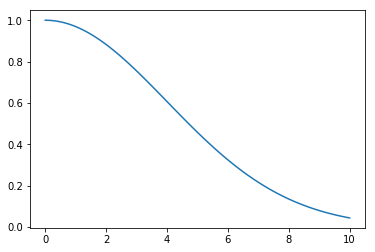

In [11]:
dist = jnp.linspace(0,10,100)
K = [Gaussian_Kernel_Norm(4)(n) for n in dist]
plt.plot(dist,K)
plt.show()